# Import Packages

In [2]:
import pandas as pd
import pyaudio
import numpy as np
from IPython import display
import os
from sklearn.preprocessing import normalize
import datetime

In [3]:
from pynput import keyboard
import wave

In [4]:
# Should see a default device, otherwise will get an error below
pa = pyaudio.PyAudio()
pa.get_default_input_device_info()

{'defaultHighInputLatency': 0.18,
 'defaultHighOutputLatency': 0.18,
 'defaultLowInputLatency': 0.09,
 'defaultLowOutputLatency': 0.09,
 'defaultSampleRate': 44100.0,
 'hostApi': 0,
 'index': 1,
 'maxInputChannels': 2,
 'maxOutputChannels': 0,
 'name': 'Microphone (Logitech USB Microp',
 'structVersion': 2}

### On keypress, record microphone
### On keyrelease, save data

In [5]:
import threading
import time
import queue

class KeyAudio(object):
    def __init__(self):
        print("Instantiating...")
        
        # I want to record for approximately 250ms for each keypress. This recording should center on the press event.
        # <---200ms---> KeyRelease <---50ms--->
        
        self.chunk = 1024
        self.format = pyaudio.paInt16
        self.channels = 1
        self.rate = 44100
        self.delta_ms = 25 # Stream read size in milliseconds
        self.full_record_ms = 250 # Key press audio recording length in milliseconds
        self.post_rel_ms = 50 # Recording time after key release in milliseconds
        
        self.row_size = int(self.rate / self.chunk * self.delta_ms * (1/1000))
        
        self.p = pyaudio.PyAudio()
        self.stream = self.p.open(format = self.format, channels = self.channels, rate = self.rate, input = True, frames_per_buffer = self.chunk)
        
        self.saving = False # Saving dataframe flag
        self.running = False # Keyboard and Audio Log started flag
        self.released = True
        self.start_time = 0.0 # Time key pressed
        self.max_hold_ms = 500 # Maximum time between hold and release for recording to be valid
        
        self.frames = [] # A list of delta_ms raw byte samples
        self.df_list = [] # Holds list of dictionaries until user saves as dataframe
        self.q = queue.Queue() # Use Queue as FIFO for recorded frames
        
        self.key_cnt = 0 # Track the number of recorded keypresses for this session
    
    # Start Listening for Keyboard Presses and recording Audio
    def startListener(self):
        print("Starting listener...")
        self.running = True
        
        # Record microphone in separate thread
        threads = []
        t = threading.Thread(target=self.log)
        threads.append(t)
        t.start()

        with keyboard.Listener(on_press=self.on_press, on_release=self.on_release) as listener:
            listener.join()
      
    # Keyboard Press
    def on_press(self, key):
        if self.released == True:
            self.start_time = time.time()
            
            self.released = False
            
    def on_release(self, key):
        self.released = True
        
        # Escape Pressed
        if key == keyboard.Key.esc:
            self.running = False
            return False # Stop Key Listener
        else:
            # Time between press and release should be less than some delta threshold
            if time.time() - self.start_time > self.max_hold_ms/1000:
                return
            # Don't record data when saving
            if self.saving:
                return
            
            print(key)
            
            time.sleep(self.post_rel_ms/1000) # Keep recording audio for some delta defined after the key is pressed
            
            if self.q.qsize() != round(self.full_record_ms/self.delta_ms):
                print("Error: Incorrect queue size: {}".format(self.q.qsize()))
                return
            
            self.frames = list(self.q.queue)
            frame_bytes = bytearray([byte for row in self.frames for byte in row])
            frames_int = np.frombuffer(frame_bytes, dtype=np.int16) # convert to int16
            
            # Create dictionary for each sample and append to list (used later to create dataframe)
            record_sample = [{'key': self.key_to_string(key), 'data': frames_int, 'raw': frame_bytes, 'timestamp': datetime.datetime.utcnow()}]
            self.df_list.extend(record_sample)
            
            # Save data to dataframe
            if self.key_cnt % 100 == 99:
                print("Saving dataframe. Session key count: {}".format(self.key_cnt))
                self.save_dataframe()
            
            self.key_cnt += 1 # New keypress recorded
            
    def key_to_string(self, key):
        key_str = ""
        if str(type(key)) == "<enum 'Key'>":
            key_str = key.name # Type <enum 'Key'
        else:
            key_str = key.char # Type pynput.keyboard._win32.KeyCode
        return key_str
            
    def log(self):
        while self.running:
            data = self.stream.read(self.chunk * self.row_size) # Raw data in byte format
            self.q.put(data)

            if self.q.qsize() > round(self.full_record_ms/self.delta_ms):
                self.q.get()

        # When run complete, stop stream
        self.stream.stop_stream()
        self.stream.close()
        self.p.terminate()
    
    def save_data_as_wav(self, data, filename="file.wav"):
        WAVE_OUTPUT_FILENAME = filename
        waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb') # 'wb' write only mode
        waveFile.setnchannels(self.channels)
        waveFile.setsampwidth(self.p.get_sample_size(self.format))
        waveFile.setframerate(self.rate)
        waveFile.writeframes(data)
        waveFile.close()
        
    def save_dataframe(self, filename='DataSet/data.pkl'):
        self.saving = True
        df = pd.DataFrame.from_records(self.df_list)
        
        # Get existing data and combine with new data
        if os.path.isfile(filename):
            df_saved = pd.read_pickle(filename)
            df = df_saved.append(df, ignore_index=True)
            
        # Save to pickle file
        df.to_pickle(filename)
        
        self.df_list = [] # Clear existing list data
        
        self.saving = False

# Data Sampling
#### Hit Esc to stop sampling

In [17]:
key = KeyAudio()
key.startListener()

Instantiating...
Starting listener...
Key.space


# Read saved dataframe

In [6]:
# Read saved list of data from object into a dataframe
df = pd.read_pickle('DataSet/data.pkl')
print(len(df))
df.head()

650


,data,key,raw,timestamp
0,"[-2, -16, -15, -12, 3, 2, 8, 11, -26, -21, -6,...",delete,"[254, 255, 240, 255, 241, 255, 244, 255, 3, 0,...",2018-07-08 17:00:03.470304
1,"[7, 6, 2, 17, -1, 1, -17, -9, 2, -4, 9, -6, -2...",t,"[7, 0, 6, 0, 2, 0, 17, 0, 255, 255, 1, 0, 239,...",2018-07-08 17:00:10.196903
2,"[47, 49, 47, 40, 44, 51, 43, 35, 30, 38, 35, 4...",h,"[47, 0, 49, 0, 47, 0, 40, 0, 44, 0, 51, 0, 43,...",2018-07-08 17:00:10.824195
3,"[-13, -21, -16, -12, -18, -24, -18, -25, -22, ...",i,"[243, 255, 235, 255, 240, 255, 244, 255, 238, ...",2018-07-08 17:00:11.529678
4,"[81, 79, 65, 78, 86, 85, 74, 79, 82, 103, 116,...",s,"[81, 0, 79, 0, 65, 0, 78, 0, 86, 0, 85, 0, 74,...",2018-07-08 17:00:11.730209


# Plot Data Row

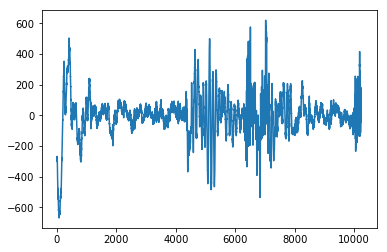

In [18]:
import matplotlib.pyplot as plt
plt.plot(df['data'][550])
plt.show()

# Save as WAV

In [20]:
key = KeyAudio()
key.save_data_as_wav(df['data'][550])

Instantiating...
